`CMPE-255. Fall 2023`
`Submitted by Bhavya Hegde`
`bhavya.hegde@sjsu.edu`

# The Traveling Salesman

Larry, a traveling salesman with Cheapsales, Inc., spends 365 (366 on leap years) days a year on the road, visiting the entire USA.

Bigspender, Inc. acquires Cheapsales. They are committed to bringing more resources into the sales organization. Larry, initially hopeful that his traveling days may be reduced, turns skeptical when his new manager states the conditions to hire more traveling salesmen:

“We shall hire the minimal number of salesman needed to cover all locations without the need for expensive air traveling”.



## The Data

| Item | Value | Notes |
| ---- | ---- | ---- |
| Locations to visit every year |	4,000	| The total number of locations the sales team needs to visit every year |
| Maximum region to region travel |	150 miles |	The total number of miles a salesman can travel on a single day from one region to another |
| Maximum working days | 240 days |	The maximum number of days a salesman will work or travel each year |
| Number of visits per day |	7 visits |	Maximum number of visits a salesman can do on a single day |
| Location affiliation | 50% red, 50% blue | The political affiliation of each location |


## Assumptions

| Assumption |
| ---- |
| The USA is a rectangle of width = 2,680 miles and height = 1,582 miles |
| Locations in the USA are randomly distributed |
| In one working day, a salesman can either visit locations or travel, but not both |
| The travel time between locations when a salesman is "visiting" is not considered |
| In every "visiting" day a salesman can only visit locations of a single affiliation (either visit "red" locations or "blue" locations, but not both |


In [ ]:
# Libraries. Add as needed
import numpy as np
import random
import matplotlib.pyplot as plt
import itertools
from sklearn.datasets import make_blobs
#new libraries below
from itertools import combinations
from scipy.spatial import distance
from sklearn.metrics import silhouette_score
from scipy.spatial import distance_matrix
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
import math

In [ ]:
# DO NOT MODIFY
SALES_LOCATIONS = 4000

MAP_WIDTH = 2680
MAP_HEIGHT = 1582

MAX_VISITS_PER_DAY = 7
MAX_TRAVEL_PER_DAY = 150
MAX_WORKING_DAYS = 240

# Utility Functions

The following utility functions can be used (or not) during the resolution of the homework. They are provided here for convenience.

In [ ]:
# DO NOT MODIFY
def create_sales_map(no_locations=SALES_LOCATIONS, map_width=MAP_WIDTH, map_height=MAP_HEIGHT, mode='random'):
  '''Function to randomly create locations and location affiliations on a square map'''

  if mode == 'random':
    locs_x = np.random.randint(map_width, size=(no_locations,1))
    locs_y = np.random.randint(map_height, size=(no_locations,1))
    #locs = np.dstack((locs_x, locs_y))[0]
    locs  = np.concatenate((locs_x, locs_y), axis=1)

  elif mode == 'blobs':
    locs, _ = make_blobs(n_samples=no_locations, n_features=2, centers=int(no_locations/50))
    minXY = np.min(locs, axis=0)
    maxXY = np.max(locs, axis=0)
    rangeXY = np.subtract(maxXY, minXY)
    ratioXY = np.divide(np.array((map_width, map_height)), rangeXY)
    s_locs = np.add(np.absolute(np.repeat([minXY], no_locations, axis=0)), locs)
    n_locs = np.multiply(ratioXY, s_locs)
    locs = n_locs.astype(int)

  else:
    print("ERROR: Unsupported mode: ", mode)
    return None, None

  # Normal distribution for affiliations: 50% red (0), 50% blue (1)
  affiliation = np.random.randint(2, size=no_locations)

  return locs, affiliation


def plot_clusters(clusters, centroids=None):
  '''Plot clusters and centroids in different colors
     clusters: Dictionary of lists. Each key is the ID of a cluster.
     centroids: List of locations'''
  colors = itertools.cycle(["green", "blue", "magenta", "yellow", "white",
                            "black", "grey", "violet", "pink", "turquoise",
                            "cyan", "purple", "orange", "olive", "brown"])
  plt.xlabel('X (miles)')
  plt.ylabel('Y (miles)')
  plt.title('Locations in a rectangular US map')
  for key in range(len(clusters.keys())):
    if len(clusters[key]) == 0:
      continue
    plt.scatter(*zip(*clusters[key]), color=next(colors), marker=".")

  if centroids != None:
    plt.scatter(*zip(*centroids), color="red", marker='^')


def plot_locations(locations, color="blue"):
  plt.xlabel('X (miles)')
  plt.ylabel('Y (miles)')
  plt.title('Locations in a rectangular US map')
  plt.scatter(*zip(*locations), color=color, marker='D')


In [ ]:
# EXAMPLE. Create a sales map with 1000 locations
random_map, random_affiliations = create_sales_map(no_locations=1000, mode='random')
blobs_map, blobs_affiliations = create_sales_map(no_locations=1000, mode='blobs')

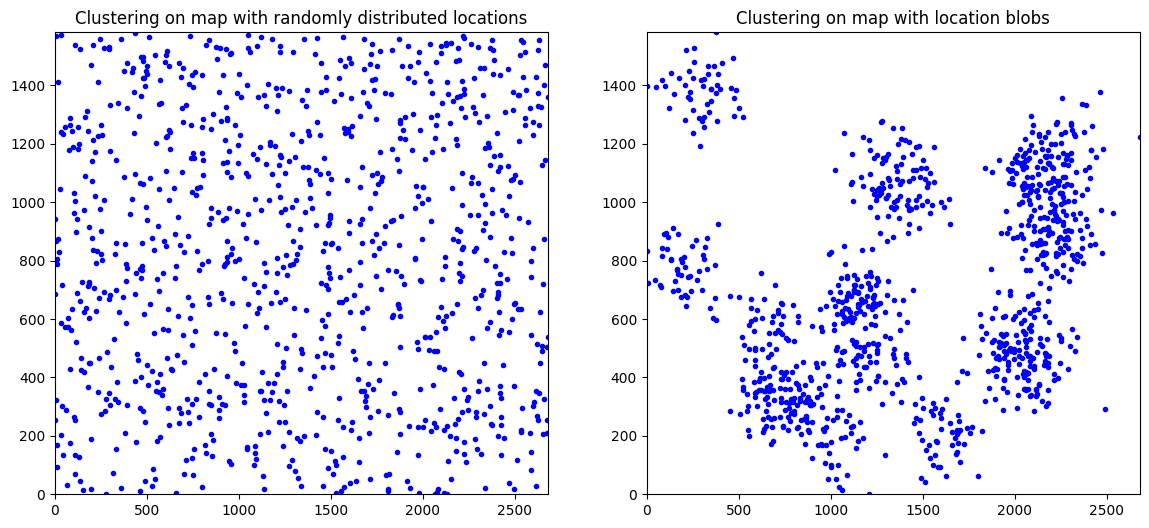

In [ ]:
# DISPLAY
fig = plt.figure(1, (14, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# PLOT Locations, then Centroids on top
ax1.scatter(*zip(*random_map), color='blue', marker=".")
ax2.scatter(*zip(*blobs_map), color='blue', marker=".")

ax1.set_ylim(0, MAP_HEIGHT)
ax1.set_xlim(0, MAP_WIDTH)
ax1.set_title("Clustering on map with randomly distributed locations")
ax2.set_ylim(0, MAP_HEIGHT)
ax2.set_xlim(0, MAP_WIDTH)
ax2.set_title("Clustering on map with location blobs")
plt.show()

# 1. Clustering without affiliation

For this deliverable ignore the "affiliation" information.

* a) Using the scikit-learn package, cluster locations to meet the requirements of the homework (except affiliation)
* b) Describe the strategy and reasons behind it
* c) Create clusters for two maps: one generated using 'random' mode, and the second using the 'blobs' mode

In [ ]:

n_clusters_random_without_affiliation = 280
n_clusters_blob_without_affiliation = 260
n_clusters_random_with_affiliation = 320
n_clusters_blob_with_affiliation = 300

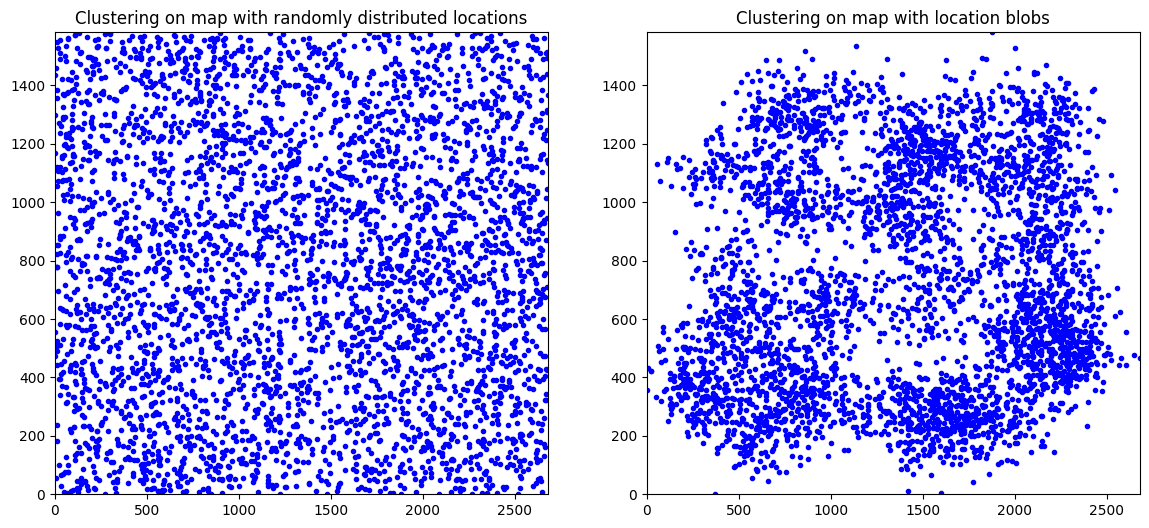

In [ ]:
from sklearn.cluster import KMeans
import warnings
# Suppress the specific FutureWarning from sklearn.cluster._kmeans
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")

# Create random and blob maps for the problem. LOCATIONS: 4000
random_map, random_affiliations = create_sales_map(no_locations=4000, mode='random')
blobs_map, blobs_affiliations = create_sales_map(no_locations=4000, mode='blobs')
# DISPLAY
fig = plt.figure(1, (14, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# PLOT Locations, then Centroids on top
ax1.scatter(*zip(*random_map), color='blue', marker=".")
ax2.scatter(*zip(*blobs_map), color='blue', marker=".")

ax1.set_ylim(0, MAP_HEIGHT)
ax1.set_xlim(0, MAP_WIDTH)
ax1.set_title("Clustering on map with randomly distributed locations")
ax2.set_ylim(0, MAP_HEIGHT)
ax2.set_xlim(0, MAP_WIDTH)
ax2.set_title("Clustering on map with location blobs")
plt.show()

## Answer 1a)

In [ ]:

def plot_kmeans_clusters(locations, n_clusters, centroids=None):
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(locations)
    counter = 0
    # Create a dictionary to store clusters
    clusters = {}
    for i, label in enumerate(cluster_labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(locations[i])

    # Calculate the maximum distances in each cluster
    max_distances = calculate_max_distances_in_clusters(clusters)

    # Print the maximum distances in each cluster
    #print("Maximum Distances in Clusters:")
    for cluster_id, max_distance in max_distances.items():
        #print(f"Cluster {cluster_id + 1}: Maximum Distance = {max_distance:.2f} miles")
        if (max_distance <= MAX_TRAVEL_PER_DAY ):
          counter = counter+1

    # Prepare data for plot_clusters function
    clusters_dict = {key: locations for key, locations in clusters.items()}

    # Plot the clusters using the plot_clusters function
    plot_clusters(clusters_dict, centroids)
    print("Count of max distances less than MAX_TRAVEL_PER_DAY: ",counter)
    print("Percentage of clusters within constrains( < 150 miles): ", ((counter*100)/n_clusters))
    #print(clusters_dict)
    return clusters_dict

def calculate_max_distances_in_clusters(clusters):
    max_distances = {}
    for cluster_id, locations in clusters.items():
        max_distance = 0
        for loc1, loc2 in combinations(locations, 2):
            distance = np.linalg.norm(np.array(loc1) - np.array(loc2))
            max_distance = max(max_distance, distance)
        max_distances[cluster_id] = max_distance
    return max_distances

## Answer 1b)

I am using K-Means clustering to create clusters of locations for solving the problem. To do this I am giving different values of clusterts (n_clusters) and
checking the max distance of points wihin the cluster. If I see that majority of the points in cluster satisfy the requirement of being within the max distance the
salesman can travel in one day (150 miles) I use that as the cluster number. I found following values to hold true, </br>
n_clusters_random_without_affiliation = 280    % of locations within cluster that fall within 150 miles distance : 93.9% </br>
n_clusters_blob_without_affiliation = 260      % of locations within cluster that fall within 150 miles distance : 94.2% </br>
n_clusters_random_with_affiliation = 320       % of locations within cluster that fall within 150 miles distance : 91.8% </br>
n_clusters_blob_with_affiliation = 300         % of locations within cluster that fall within 150 miles distance : 95% </br>



## Answer 1c)

Count of max distances less than MAX_TRAVEL_PER_DAY:  262
Percentage of clusters within constrains( < 150 miles):  93.57142857142857


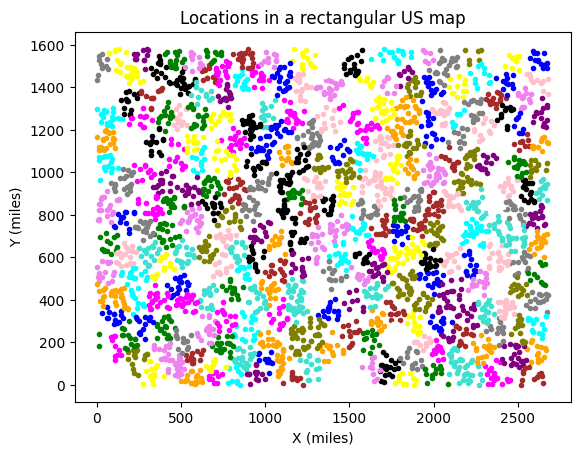

In [ ]:
#ANSWER 1 c)     Clustering on Random map without affiliation.

random_map_clusters = plot_kmeans_clusters(random_map, n_clusters=n_clusters_random_without_affiliation, centroids=None)

Count of max distances less than MAX_TRAVEL_PER_DAY:  245
Percentage of clusters within constrains( < 150 miles):  94.23076923076923


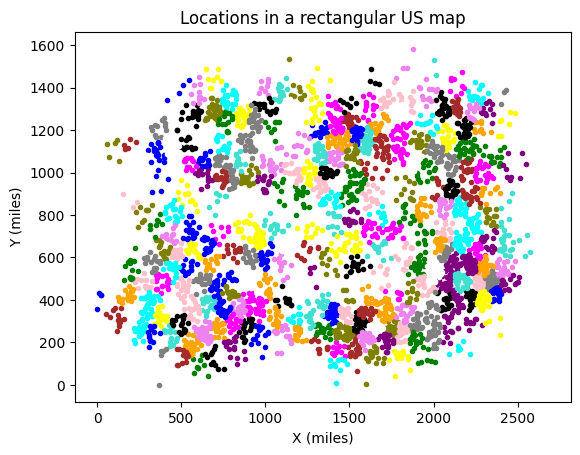

In [ ]:
#ANSWER 1c) Clustering on Blob map without affiliation.

blobs_map_clusters = plot_kmeans_clusters(blobs_map, n_clusters=n_clusters_blob_without_affiliation, centroids=None)

# 2. Clustering with affiliation

Considering the "affiliation" information.

* a) Cluster locations to meet the requirements of the homework (all requirements, including the "affiliation")
This clustering can be done either using scikit-learn functions, or creating a custom KMeans function. Either approach is acceptable.
* b) Describe the strategy and reasons behind it
* c) Create clusters for two maps: one generated using 'random' mode, and the second using the 'blobs' mode

## Answer 2a)

In [ ]:

def kmeans_clusters_with_affiliation(locations, affiliations, n_clusters, centroids=None):
    # Create a custom feature by combining spatial distance and affiliation
    data = np.column_stack((locations, affiliations))
    custom_feature = np.zeros((data.shape[0], 1))
    counter = 0
    for i in range(data.shape[0]):
        spatial_distance = np.linalg.norm(data[i, :2] - data[:, :2], axis=1)
        affiliation_distance = (data[i, 2] != data[:, 2]).astype(float)
        combined_distance = spatial_distance + affiliation_distance
        custom_feature[i] = np.max(combined_distance)

    # Add the custom feature to the data
    data = np.column_stack((data, custom_feature))

    # Perform K-Means clustering with the augmented data
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(data)

    # Create a dictionary to store clusters
    clusters = {}
    for i, label in enumerate(cluster_labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(locations[i])
    # Calculate the maximum distances in each cluster
    max_distances = calculate_max_distances_in_clusters(clusters)

    # Print the maximum distances in each cluster
    #print("Maximum Distances in Clusters:")
    for cluster_id, max_distance in max_distances.items():
        #print(f"Cluster {cluster_id + 1}: Maximum Distance = {max_distance:.2f} miles")
        if (max_distance <= MAX_TRAVEL_PER_DAY ):
          counter = counter+1

    # Prepare data for plot_clusters function
    clusters_dict = {key: locations for key, locations in clusters.items()}

    # Plot the clusters using the plot_clusters function
    plot_clusters(clusters_dict, centroids)
    print("Count of max distances less than MAX_TRAVEL_PER_DAY: ",counter)
    print("Percentage of clusters within constrains( < 150 miles): ", ((counter*100)/n_clusters))
    return clusters_dict

##Answer 2b)

I am using K-Means clustering to create clusters of locations for solving the problem. To do this I am giving different values of clusterts (n_clusters) and
checking the max distance of points wihin the cluster. If I see that majority of the points in cluster satisfy the requirement of being within the max distance the
salesman can travel in one day (150 miles) I use that as the cluster number. I found following values to hold true,</br>
n_clusters_random_without_affiliation = 280    % of locations within cluster that fall within 150 miles distance : 93.9% </br>
n_clusters_blob_without_affiliation = 260      % of locations within cluster that fall within 150 miles distance : 94.2% </br>
n_clusters_random_with_affiliation = 320       % of locations within cluster that fall within 150 miles distance : 91.8% </br>
n_clusters_blob_with_affiliation = 300         % of locations within cluster that fall within 150 miles distance : 95% </br>

To account for affiliation information, I am creating a custom feature which combines the spatial distance information along with the associated affiliation information,
to create a combined distance which is used to calculate the K-means clustering.


## Answer 2c)

Count of max distances less than MAX_TRAVEL_PER_DAY:  287
Percentage of clusters within constrains( < 150 miles):  89.6875


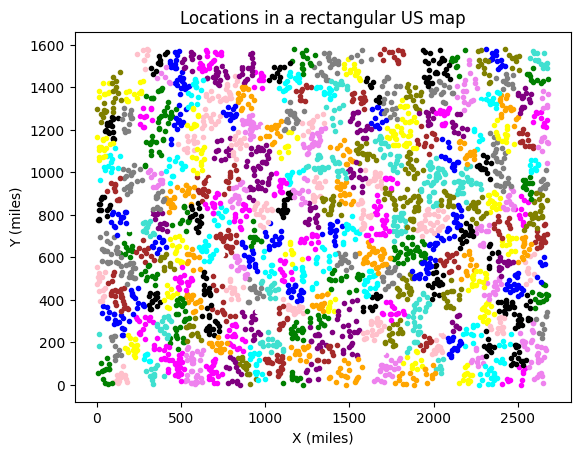

In [ ]:

#ANSWER 2 c) Clustering on Random map with affiliation.

random_map_affiliation_clusters = kmeans_clusters_with_affiliation(random_map, random_affiliations, n_clusters=n_clusters_random_with_affiliation, centroids=None)

Count of max distances less than MAX_TRAVEL_PER_DAY:  285
Percentage of clusters within constrains( < 150 miles):  95.0


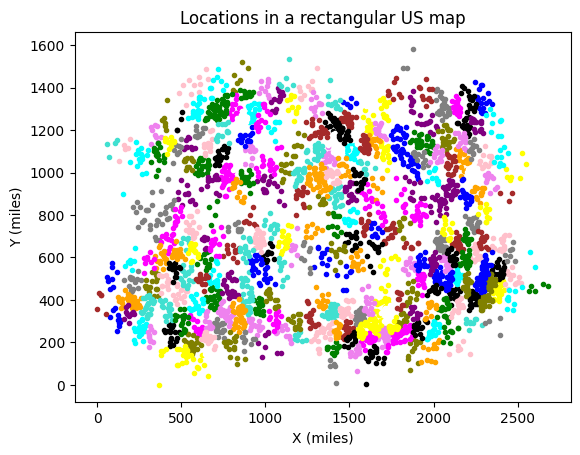

In [ ]:
# ANSWER 2 c) Clustering on Blob map with affiliation.
blobs_map_affiliation_clusters = kmeans_clusters_with_affiliation(blobs_map, blobs_affiliations, n_clusters=n_clusters_blob_with_affiliation, centroids=None)

# 3. Quality of the clustering

* a) Select and describe at least one quality measure for the clusters.
* b) Apply the quality measure to the clustered data from deliverables 1 and 2. Display the results. There should be four results, one for each of the clusters created in 1 and 2.

## Answer 3a)

To measure the quality of clusters I am going to use Silhouette score.
The Silhouette Score assesses the compactness and separation of clusters, providing a measure of how well-separated and distinct the clusters are from each other. It ranges from -1 to 1, where:
A high Silhouette Score close to 1 indicates that the clusters are well-separated and points within the same cluster are tightly grouped together. A Silhouette Score close to 0 suggests overlapping clusters or clusters with points that are on or very close to the decision boundary between clusters. A negative Silhouette Score (-1) indicates that data points have been assigned to the wrong clusters.



## Answer 3b)

In [ ]:


#ANSWER 3 b)

def calculate_silhouette_score(clusters, locations):
    # Combine all locations from the clusters into a single list
    all_locations = [location for locations_list in clusters.values() for location in locations_list]

    # Create a list of cluster labels corresponding to each location
    cluster_labels = []
    for label, locations_list in clusters.items():
        cluster_labels.extend([label] * len(locations_list))

    # Calculate the Silhouette Score
    silhouette_avg = silhouette_score(all_locations, cluster_labels)

    return silhouette_avg

silhouette_score_value = calculate_silhouette_score(random_map_clusters,random_map)
print("\nSilhouette scores for maps from Deliverable 1 \n")
print(f"Silhouette Score : Random Map Without affiliation: {silhouette_score_value:.2f}")
silhouette_score_value = calculate_silhouette_score(blobs_map_clusters,blobs_map)
print(f"Silhouette Score : Blobs Map Without affiliation: {silhouette_score_value:.2f}")
print("\nSilhouette scores for maps from Deliverable 2 \n")
silhouette_score_value = calculate_silhouette_score(random_map_affiliation_clusters,random_map)
print(f"Silhouette Score : Random Map With affiliation: {silhouette_score_value:.2f}")
silhouette_score_value = calculate_silhouette_score(random_map_affiliation_clusters,blobs_map)
print(f"Silhouette Score : Blobs Map With affiliation: {silhouette_score_value:.2f}")


Silhouette scores for maps from Deliverable 1 

Silhouette Score : Random Map Without affiliation: 0.36
Silhouette Score : Blobs Map Without affiliation: 0.35

Silhouette scores for maps from Deliverable 2 

Silhouette Score : Random Map With affiliation: 0.34
Silhouette Score : Blobs Map With affiliation: 0.34


# 4. Answer to the main question: How many salesman are needed

* a) Based on the data and assumptions, calculate how many salesmen are needed to meet all constraints. Provide the number for the 4 clusters done in deliverables 1 and 2.
* b) Explain what assumptions (beyond the ones already provided above) are made to reach the numbers in 4.a. You are at liberty to apply any additional assumptions you want, specially if they make the analysis easier.
* c) Provide a table of "Average work load for all salesmen", for each case.

##Answer 4a)

Based on data and assumptions I created a function named employee_count which takes number of clusters as a parameter to calculate the minimum number of employees required to cover,
all the locations and the clusters assigned to them. We have assumed time taken to go from one cluster to another is 1 day and this is added to the number of days the employee will take
to cover locations within the cluster.

Employee Count for Random map without affiliation:  5 </br>
Employee Count for Blob map without affiliation:  5</br>
Employee Count for Random map with affiliation:  4 </br>
Employee Count for Blob Random map with affiliation:  4 </br>

In [ ]:

def workload_calculator_without_affiliation(n_clusters,n_employees):
	n_clusters = n_clusters
	n_employees = n_employees
	location_per_cluster  = math.ceil(SALES_LOCATIONS/n_clusters)
	days_per_cluster = math.ceil(location_per_cluster/MAX_VISITS_PER_DAY)
	clusters_to_be_handled = math.ceil( n_clusters / n_employees )
	days_needed_to_travel = clusters_to_be_handled
	total_days_per_employee = days_needed_to_travel + (clusters_to_be_handled * days_per_cluster)
	return total_days_per_employee

def workload_calculator_with_affiliation(n_clusters,n_employees):
  n_clusters = n_clusters
  n_employees = n_employees
  location_per_cluster  = math.ceil(SALES_LOCATIONS/n_clusters)
  red_locations_per_cluster = blue_locations_per_cluster = math.ceil(location_per_cluster/2)

  days_per_cluster = math.ceil(red_locations_per_cluster/MAX_VISITS_PER_DAY) + math.ceil(blue_locations_per_cluster/MAX_VISITS_PER_DAY)
  clusters_to_be_handled = math.ceil( n_clusters / n_employees )
  days_needed_to_travel = clusters_to_be_handled
  total_days_per_employee = days_needed_to_travel + (clusters_to_be_handled * days_per_cluster)
  return total_days_per_employee

def employee_count(n_clusters):
  days_per_cluster = math.ceil(SALES_LOCATIONS/(n_clusters*MAX_VISITS_PER_DAY))
  n_employees = math.ceil(((1+days_per_cluster) *n_clusters)/MAX_WORKING_DAYS)
  return n_employees


## Answer 4b)


*   To calculate the number of employees we need to find what is the minimun employee count required such that the workload for each employee is less than 240 days.
*   We assume that no time is required to travel between the allowed 7 visits per day within the cluster.
* We are calculating workload based on total number of days required by each employee which includes days for travel and days for conducting visits within clusters.

## Answer 4c)

In [ ]:
#ANSWER 4 c)

employee_count_random_map_without_affiliation = employee_count(n_clusters=n_clusters_random_without_affiliation)
employee_count_blob_map_without_affiliation=employee_count(n_clusters=n_clusters_blob_without_affiliation)
employee_count_random_map_with_affiliation=employee_count(n_clusters=n_clusters_random_with_affiliation)
employee_count_blob_map_with_affiliation=employee_count(n_clusters=n_clusters_blob_with_affiliation)

print("Employee Count for Random map without affiliation: ",employee_count_random_map_without_affiliation)
print("Employee Count for Blob map without affiliation: ",employee_count_blob_map_without_affiliation)
print("Employee Count for Random map with affiliation: ",employee_count_random_map_with_affiliation)
print("Employee Count for Blob Random map with affiliation: ",employee_count_blob_map_with_affiliation)

workload_random_map_without_affiliation = workload_calculator_without_affiliation(n_clusters=n_clusters_random_without_affiliation,n_employees=employee_count_random_map_without_affiliation)
workload_blob_map_without_affiliation=workload_calculator_without_affiliation(n_clusters=n_clusters_blob_without_affiliation,n_employees=employee_count_blob_map_without_affiliation)
workload_random_map_with_affiliation=workload_calculator_with_affiliation(n_clusters=n_clusters_random_with_affiliation,n_employees=employee_count_random_map_with_affiliation)
workload_blob_map_with_affiliation=workload_calculator_with_affiliation(n_clusters=n_clusters_blob_with_affiliation,n_employees=employee_count_blob_map_with_affiliation)
print("\nWorkload per employee based on Random map/Blob map and with/without affiliation. \n")
print("Average Workload per employee(in days) for Random map without affiliation: ",workload_random_map_without_affiliation)
print("Average Workload per employee(in days) for Blob map without affiliation: ",workload_blob_map_without_affiliation)
print("Average Workload per employee(in days) for Random map with affiliation: ",workload_random_map_with_affiliation)
print("Aveerage Workload per employee(in days) for Blob map with affiliation: ",workload_blob_map_with_affiliation)


Employee Count for Random map without affiliation:  5
Employee Count for Blob map without affiliation:  5
Employee Count for Random map with affiliation:  4
Employee Count for Blob Random map with affiliation:  4

Workload per employee based on Random map/Blob map and with/without affiliation. 

Average Workload per employee(in days) for Random map without affiliation:  224
Average Workload per employee(in days) for Blob map without affiliation:  208
Average Workload per employee(in days) for Random map with affiliation:  240
Aveerage Workload per employee(in days) for Blob map with affiliation:  225


# 5. Anomaly Detection
Consider only the 'blobs' map in deliverable 1.
* a) Using the scikit-learn functions, identify anomalies in the map locations.
The definition of an anomaly in this example would be: "Isolated locations, i.e., locations farther than 75 miles of any locations, and with at most 3 locations closer than 125 miles"





##Answer 5a)
I m using DBSCAN method to calculate anomaly which are points farther than 75 miles from other points. I then calculate number of neighbors the farthest locations have which
are within 125 miles. If the farthest loction has more than 3 neighbors that are closer than 125 miles, they are dropped. The ones that remain are all marked as
Isolated locations in the mark with red color, all the other locations are marked in grey color.

## Answer 5b)
Display a map with all locations in grey color, and the anomalies in red color

Locations farther than 75 miles from any other location:
[[ 156  899]
 [2394  233]
 [1600    4]
 [ 417 1340]
 [1878 1582]
 [1140 1534]
 [ 369    0]
 [1387 1438]
 [2605  556]
 [1772   41]]
Number of neighbors for father_locations within 125 miles radius
{(156, 899): 5, (2394, 233): 5, (1600, 4): 5, (417, 1340): 10, (1878, 1582): 3, (1140, 1534): 2, (369, 0): 1, (1387, 1438): 12, (2605, 556): 11, (1772, 41): 16}
Filtered neighbors_dict (items where value <= 3):
{(1878, 1582): 3, (1140, 1534): 2, (369, 0): 1}


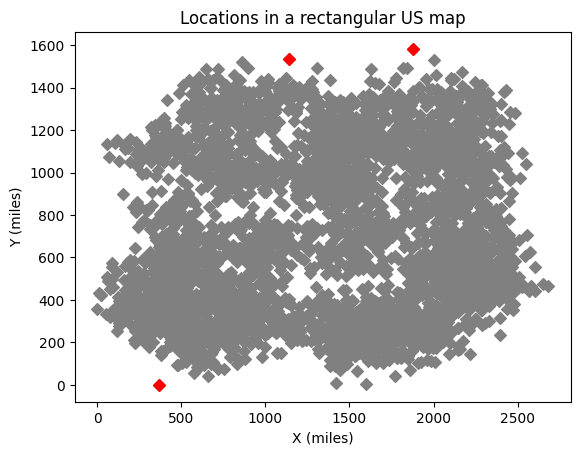

In [ ]:

locations = blobs_map

# Calculate the pairwise distances between locations
distances = pairwise_distances(locations, metric='euclidean')

# Create a DBSCAN model
eps = 75.0  # Maximum distance to be considered a neighbor
min_samples = 2  # Minimum number of samples in a cluster (including itself)
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
dbscan_model.fit(distances)
cluster_labels = dbscan_model.labels_

# Find locations that are labeled as noise (-1) since they are farther than 75 miles from any other location
farther_locations = locations[cluster_labels == -1]

# Now, farther_locations contains locations that are farther than 75 miles from any other location
print("Locations farther than 75 miles from any other location:")
print(farther_locations)


distances_between_farther_and_all = pairwise_distances(farther_locations, locations, metric='euclidean')

neighbors_dict = {}

# Define the radius (125 miles)
radius = 125.0

for i, location in enumerate(farther_locations):
    # Get distances between the current 'farther_location' and all 'locations'
    distances_to_all = distances_between_farther_and_all[i]

    # Count the number of neighbors closer than 125 miles
    num_neighbors = np.sum(distances_to_all < radius)

    # Store the count in the dictionary with the 'farther_location' as the key
    neighbors_dict[tuple(location)] = num_neighbors

print("Number of neighbors for father_locations within 125 miles radius")
print(neighbors_dict)
filtered_neighbors_dict = {key: value for key, value in neighbors_dict.items() if value <= 3}

# Now, 'filtered_neighbors_dict' contains only the items where the value is <= 3
print("Filtered neighbors_dict (items where value <= 3):")
print(filtered_neighbors_dict)

plot_locations(locations, color="gray")

# Extract the points from 'filtered_neighbors_dict' as NumPy array
red_points = np.array(list(filtered_neighbors_dict.keys()))

# Plot the points from 'filtered_neighbors_dict' as red
plot_locations(red_points, color="red")


#ANSWER 5 b)
# Show the Isolated Locations plot
plt.show()